<a href="https://colab.research.google.com/github/najinkya1313/solar-limb-darkening/blob/main/limb_darkening_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solar Limb Darkening Experiment**
**- By Ajinkya Naik**

This notebook explores the phenomenon of solar limb darkening, where the Sun's disk appears darker towards its edges (limb) than at its center [[1]](https://web.iucaa.in/~dipankar/ph217/contrib/limb.pdf). We will process raw solar images, calibrate them, and then define annuli across the disk to obtain the intensity variation and quantify limb darkening.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
!pip install rawpy
import rawpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.0 MB/s eta 0:00:00


First, let us define a function to read the raw image files in the *.nef* format and obtain the image data for the three color channels - R, G and B.

In [ ]:
def read_raw_nef(filepath):
    with rawpy.imread(filepath) as raw:
        imdata = raw.postprocess(
            demosaic_algorithm=rawpy.DemosaicAlgorithm.AHD,
            no_auto_bright=True,
            use_camera_wb=False,
            output_color=rawpy.ColorSpace.raw,
            gamma=(1, 1),
            output_bps=8
        )

    imdata = imdata.astype(np.float32)

    R = imdata[:, :, 0]
    G = imdata[:, :, 1]
    B = imdata[:, :, 2]
    return R, G, B

Next, we use this function to read and get the image data for our light, dark and flat frames.

(Tip: It will be convenient to create a directory with your lights, darks and flats in separate folders. If you are running this notebook using Google Collab, you will need to upload the files to your Google Drive and mount the drive to this notebook.)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
light_r,light_g,light_b = read_raw_nef('/content/drive/MyDrive/Solar Images/Lights/light_28_Jan.NEF')#you might need to change this to the filepath where your images are located.
## load the dark, flats and flat-darks similarly

Let's see how the images look like in the different channels.

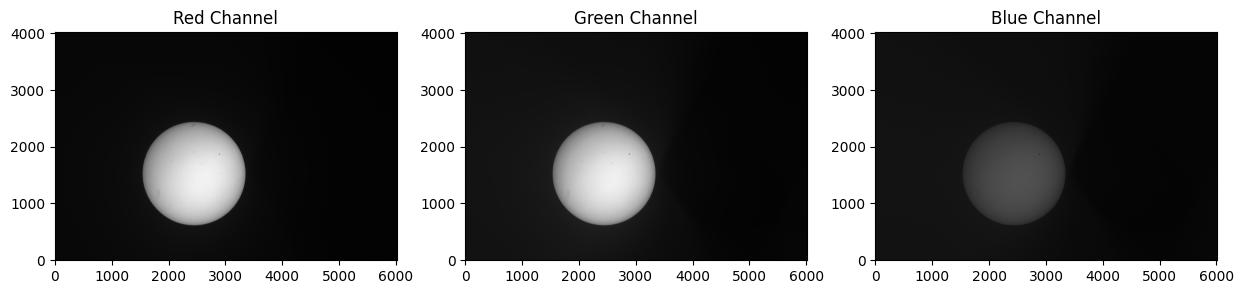

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(light_r,origin='lower',cmap='grey')
axes[1].imshow(light_g,origin='lower',cmap='grey')
axes[2].imshow(light_b,origin='lower',cmap='grey')
axes[0].set_title('Red Channel')
axes[1].set_title('Green Channel')
axes[2].set_title('Blue Channel')
plt.show()

Notice the varying brightness of the solar disk across the channels. In which of the three channels does the image appear brightest?
We will stick with the Green channel for the rest of our analysis, but you might as well try it on the others.




#1. Image Calibration
The pixel counts of our raw images is a result of contributions from several sources apart from the object of interest (the Sun in our case). These could be sources of noise such as the dark current generated in the camera, read noise intrinsic to the electronics of our imaging system, background and ambient noise from the sky, and so on. Furthermore, the sensitivity of our detectors varies from pixel-to-pixel due to numerous factors. Image calibration aims to remove some of these non-celestial counts from the image and correct for the non-uniform sensitivity of the detector [[2]](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/01-05-Calibration-overview.html). The central equation for the pixel counts in our raw image is:

\begin{equation}
C_{\text{raw}} = C_{\text{noise}} + C_{\text{dark}} + G(x,y) [C_{\text{background}} + C_{\text{source}}]
\end{equation}

Here, $G(x,y)$ refers to the pixel-dependent sensitivity of our detector, while rest of the variables are self-explanatory. In the case of solar imaging, the Signal-to-Noise ratio is sufficiently high and so we can safely ignore $C_{\text{noise}}$ and $C_{\text{background}}$. Solving the above equation for $C_{\text{source}}$:

\begin{equation}
C_{\text{source}} = \frac{C_{\text{raw}} - C_{\text{dark}}}{G(x,y)}
\end{equation}

The $C_{\text{dark}}$ and $G(x,y)$ are obtained using the dark and normalized flat-field frames, respectively. Therefore, we use the above equation for $C_{\text{source}}$ to get the final calibrated image.

**Task 1.1: Combine the multiple darks, flats and flat-darks into a single master-frame using median stacking.**

(Hint : you can use np.stack and np.median with "*axis=0*" argument for this.)

**Task 1.2: Calibrate the flat-field frames by subtracting the flat darks and then normalize the counts.**

**Task 1.3: Using the equation for $C_{\text{source}}$**, obtain the final calibrated image. Store the image data into a variable named *calibrated*.

#2. Solar Disk Fitting
In order to estimate the solar radius and pixel coordinates of the centre in the image, we need to isolate the solar disk from the background. This can be done by fitting a circle to the disk. Since we expect the brightness to drop off sharply at the limb, the gradient of the image data can be used to create a mask.

In [ ]:
smooth = gaussian_filter(calibrated, sigma=2)

**Task 2.1: Use the gradient of the image data (*np.gradient*) to create a mask and identify the limb points. Call this the *edge_mask*.**

(Hint : We expect the **magnitude** of the gradient $\sqrt{dx^2+dy^2}$ to be maximum at the limb and the sunspots.)

Now that the limb points are estimated, we can fit a circle to the disk using an algebraic, least squares algorithm known as the Kasa method [[3]](https://www.ne.jp/asahi/paleomagnetism.rock-magnetism/basics/pmag/circ/circ1E.html). However, you can use any other simpler methods.

In [ ]:
yy, xx = np.indices(smooth.shape)

# Rough center estimate
xc0 = np.mean(xx[edge_mask])
yc0 = np.mean(yy[edge_mask])

rr0 = np.sqrt((xx - xc0)**2 + (yy - yc0)**2)

r_estimate = np.median(rr0[edge_mask])
limb = edge_mask & (np.abs(rr0 - r_estimate) < 100)

x = xx[limb]
y = yy[limb]

def fit_circle(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)

    u = x - x_m
    v = y - y_m

    Suu = np.sum(u*u)
    Suv = np.sum(u*v)
    Svv = np.sum(v*v)
    Suuu = np.sum(u*u*u)
    Svvv = np.sum(v*v*v)
    Suvv = np.sum(u*v*v)
    Svuu = np.sum(v*u*u)

    A = np.array([[Suu, Suv],
                  [Suv, Svv]])
    B = np.array([(Suuu + Suvv)/2,
                  (Svvv + Svuu)/2])

    uc, vc = np.linalg.solve(A, B)

    xc = x_m + uc
    yc = y_m + vc
    r = np.sqrt(uc**2 + vc**2 + (Suu + Svv)/len(x))

    return xc, yc, r

xc, yc, r = fit_circle(x, y)

print(f"Center: ({xc:.1f}, {yc:.1f}), Radius: {r:.1f}")

##visualizing the fit

theta = np.linspace(0, 2*np.pi, 400)

plt.imshow(smooth, origin="lower", cmap="gray")
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), 'r',lw=0.3)
plt.plot(xc + 0.04*r*np.cos(theta), yc + 0.04*r*np.sin(theta), 'r') #centroid used later in normalizing intensity.
plt.show()

#3. Calculating the Limb Darkening Profile
We can now define a series of concentric circles on the solar disk. The average intensity of each annulus, which is the region bounded between any two concentric circles, will be used for calculating the limb darkening profile. We will define a total of 50 annuli for calculating the limb darkening profile.

In [ ]:
rr = np.sqrt((xx - xc)**2 + (yy - yc)**2)
mu = np.sqrt(1 - (rr / r)**2)
disk_mask = rr <= r

n_annuli = 50
edges = np.linspace(0, r, n_annuli + 1)

/tmp/ipython-input-103351321.py:2: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - (rr / r)**2)


**Task 3.1: Define a series of annuli on the disk. Calculate the average intensities and their standard deviation in each annulus. Also define a centroid to calculate the central intensity $I(0,0)$. Normalize the average intensities by the central intensity $I(0,\theta)/I(0,0)$. Plot this against $\mu$ and against the mean radial distance of the annulus to obtain the limb darkening profile.**

#4. Fitting to the Linear Limb Darkening law.
The normalized intensities $I(0,\theta)/I(0,0)$ for the $\mu = cos\theta$ values of annuli can be fit to a linear limb darkening law to obtain the limb darkening coefficient:
\begin{equation}
\frac{I(0,\theta)}{I(0,0)} = 1 - u_\nu(1-\mu)
\end{equation}

where $u_\nu$ is the wavelength-dependent, linear limb darkening coefficient.

In [ ]:
def linear_ld(mu, u):
    return 1 - u * (1 - mu)

**Task 4.1: Use *scipy.curve_fit* to fit the above function to the obtained normalized intensities and $\mu$. Obtain the optimal parameter fit from the *popt* matrix and the error in the fit from the diagonal value of the covariance matrix.**

Tip: Set the *sigma* parameter in *curve_fit* to be equal to the standard deviations of the intensities $\sigma_I$ calculated in each annulus. Also set *absolute_sigma = True*.

**Task 4.2: Finally, visualize the observed limb darkening profile alongside the theoretical curves for the expected and observed values of the limb darkening coefficients. Your plots shoud resemble those shown in the experiment manual.**

The ideal expected value of the limb darkening coefficient in the visible wavelength should lie between $0.6$ to $0.7$.

#Conclusion
In conclusion, we have successfully analyzed solar images to quantify limb darkening. We started by processing the raw NEF files, performing calibration steps using dark and flat frames, and an algebraic circle-fitting method (Kasa method) to accurately determine the solar disk's center and radius.

We used the annulus method to extract the average intensity profile as a function of normalized radius and $\mu=cos\theta$. Fitting this profile to a linear limb darkening law yielded a linear limb darkening coefficient of u = 0.6054, which aligns well with expected theoretical values for solar observations in the visible spectrum. The visualization further confirms the observed limb darkening effect, where the intensity decreases significantly towards the limb of the Sun.



#Things to try


1. Repeat these steps for the image data from other color channels. Does the linear limb darkening coefficient and profile change, if at all?


2. We used the annuli method in this tutorial which gives a symmetric limb darkening profile for the normalized radius $r=0$ to $r=1$. Try defining a thin strip of the disk using two line chords, and sample the average intensity at each radial distance within this plane. This "line method" gives the limb darkening profile from $r=-1$ to $r=1$. Is there an asymmetry in this profile? If your sampling line contains sunspots then this should result in more apparent dips in the profile.


3. The gradient method also picked up some sunspots on the disk. You can compare the positions of these sunspots in images from different days. Define a grid of latitudes and longitudes on the disk to do this. Do the coordinates of the sunspots change for different days? Is the amount of change same for all latitudes? (Hint: This activity aims to measure/demonstrate the differential rotation of the Sun [[4]](https://cesar.esa.int/upload/201710/suns_differential_rotation_students_guide_intermediate_level_008.pdf).)



#References
[1] https://web.iucaa.in/~dipankar/ph217/contrib/limb.pdf

[2] https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/01-05-Calibration-overview.html

[3] https://www.ne.jp/asahi/paleomagnetism.rock-magnetism/basics/pmag/circ/circ1E.html

[4] https://cesar.esa.int/upload/201710/suns_differential_rotation_students_guide_intermediate_level_008.pdf